https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

## Importing modules
### Seperated between libraries to keep track

In [1]:
import numpy as np

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from xgboost import XGBRegressor

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [6]:
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Function Building

In [103]:
"""CORRELATED FEATURES"""
"""
train = pd.read_csv("../data/train_correlated.csv")

X_test = pd.read_csv("../data/test_correlated.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y_all = train["SalePrice"]
X_all = train.drop(columns=["SalePrice"])[headers]
"""

'\ntrain = pd.read_csv("../data/train_correlated.csv")\n\nX_test = pd.read_csv("../data/test_correlated.csv")\nX_test_id = pd.read_csv("../data/raw_test.csv")["Id"]\n\nheaders = X_test.columns\n\ny_all = train["SalePrice"]\nX_all = train.drop(columns=["SalePrice"])[headers]\n'

In [104]:
"""ALL FEATURES [X, y]"""
train = pd.read_csv("../data/data_all_features.csv")

X_test = pd.read_csv("../data/test_all_features.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y_all = train["SalePrice"]
X_all = train.drop(columns=["SalePrice"])[headers]

X, X_hold, y, y_hold = train_test_split(X_all,y_all)

X_hold = X_hold.reset_index()
y_hold = y_hold.reset_index()

original_index = y_hold["index"]
X_hold = X_hold.drop(columns = ["index"])
y_hold = y_hold.drop(columns = ["index"])

"""20% CORRELATED FEATURES [X_20, y_20]"""
features_20 = pd.read_csv("../data/test_correlated.csv").columns
X_20 = X[features_20]
X_hold_20 = X_hold[features_20]

In [105]:
def XGB_val_in_hyperopt(XGBModel, X, y, early_stop_num = 10):
    X_train, X_valid, y_train, y_valid = train_test_split(X,y)
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    XGBModel.fit(X_train, y_train,
                eval_set=evaluation, 
                eval_metric="mae",
                early_stopping_rounds=early_stop_num,
                verbose=False
                )
    predict = XGBModel.predict(X_valid)
    accuracy = XGBModel.predict(X_valid)
    n_est_used = len(XGBModel.get_booster().get_dump())
    
    return accuracy, n_est_used

In [106]:
"""Linear Regressor"""
def linear_objective(space):
    clf=XGBRegressor(
                    n_estimators = int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'],
                    reg_lambda = space['reg_lambda'],
                    min_child_weight= space['min_child_weight'],
                    colsample_bytree= space['colsample_bytree'],
    )
    
    
    acc = []
    n_est = []
    for i in range(5):
        accuracy, n_est_used = XGB_val_in_hyperopt(XGBModel = clf, X = X, y = y, early_stop_num = 10)
        acc.append(accuracy)
        n_est.append(n_est_used)
    
    accuracy = np.mean(acc)
    n_est_used = int(np.mean(n_est))
    
    trials.results[-1]["n_estimators"] = n_est_used
    
    trials.trials[-1]["misc"]["vals"]["n_estimators"] = [n_est_used]
    
    return {'loss': accuracy, 'status': STATUS_OK, "n_estimators" : n_est_used}

In [111]:
def XGB_optimised_model(X, y, X_test, num_search = 100): ##NUM SEARCH = 100
    global trials
    trials = Trials()

    best_hyperparams = fmin(fn = linear_objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = num_search,
                            trials = trials)
    clf=XGBRegressor(
                n_estimators = int(best_hyperparams['n_estimators']), 
                max_depth = int(best_hyperparams['max_depth']), 
                gamma = best_hyperparams['gamma'],
                reg_alpha = best_hyperparams['reg_alpha'],
                reg_lambda = best_hyperparams['reg_lambda'],
                min_child_weight = best_hyperparams['min_child_weight'],
                colsample_bytree = best_hyperparams['colsample_bytree']
    )

    clf.fit(X, y, 
            eval_metric="mae",
            verbose=True
    )

    predict = clf.predict(X_test)

    return predict, best_hyperparams, clf

In [112]:
def XGB_optimised_ensamble(X, y, X_test, num_search = 10, num_models = 10):
    predictions = {}
    parameters = {}
    models = {}
    
    for i in range(num_models):
        predictions["model_"+str(i)], parameters["model_"+str(i)], models["model_"+str(i)] = XGB_optimised_model(X, y, X_test, num_search)
    
    return predictions, parameters, models

In [113]:
def test_ensamble(ensamble_models, X_test):
    n_models = len(ensamble_models)
    predictions = pd.DataFrame()
    for i in range(n_models):
        model = "model_"+str(i)
        clf = ensamble_models[model]
        predictions[model] = clf.predict(X_test)
    
    return predictions

In [114]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 999, 1000, 1),
        'seed': 0
    }

In [15]:
predictions, parameters, models = XGB_optimised_ensamble(X, y, X_test = X_hold, num_search = 5, num_models = 2)

 20%|███████████                                            | 1/5 [00:07<00:30,  7.71s/trial, best loss: 184278.078125]


KeyboardInterrupt: 

In [ ]:
model_predictions = pd.DataFrame(predictions)
comparison = pd.DataFrame({"Original Index":original_index,"Predictions":model_predictions.mean(axis=1), "SalePrice":y_hold["SalePrice"]})
comparison["Delta"] = comparison["Predictions"] - comparison["SalePrice"]

In [ ]:
comparison["Delta"] = np.abs(comparison["Predictions"] - comparison["SalePrice"])
comparison["Error"] = comparison["Delta"]/comparison["SalePrice"]

In [ ]:
ensamble_predictions = test_ensamble(ensamble_models = models, X_test = X_test).mean(axis=1)

In [ ]:
submission = pd.DataFrame({"Id":X_test_id,"SalePrice":ensamble_predictions})
submission.to_csv("../skl-XGBoost/submission.csv", sep =",", index = False)

# Testing Different Datasets

In [163]:
"""ALL FEATURES [X, y]"""
train = pd.read_csv("../data/data_all_features.csv")

X_test = pd.read_csv("../data/test_all_features.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y_all = train["SalePrice"]
X_all = train.drop(columns=["SalePrice"])[headers]

X, X_hold, y, y_hold = train_test_split(X_all,y_all)

X_hold = X_hold.reset_index()
y_hold = y_hold.reset_index()

original_index = y_hold["index"]
X_hold = X_hold.drop(columns = ["index"])
y_hold = y_hold.drop(columns = ["index"])

"""20% CORRELATED FEATURES [X_20, y_20]"""
features_20 = pd.read_csv("../data/test_correlated.csv").columns
X_20 = X[features_20]
X_hold_20 = X_hold[features_20]

In [164]:
predictions_all = pd.DataFrame()
acc_all = pd.DataFrame()
model_scores_all = pd.DataFrame()

In [165]:
for i in range(25):
    n = len(predictions_all.columns)
    predictions, parameters, models = XGB_optimised_ensamble(X, y, X_test = X_hold, num_search = 1, num_models = 1)
    predictions_all["model_"+str(n)] = predictions["model_0"]
    model_scores_all["model_"+str(n)] = [mean_absolute_error(predictions["model_0"], y_hold)]
    acc_all[str(n+1)+"_models"] = [float(model_scores_all.mean(axis = 1))]

100%|██████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/trial, best loss: 176834.625]


In [166]:
predictions_20 = pd.DataFrame()
acc_20 = pd.DataFrame()
model_scores_20 = pd.DataFrame()

In [167]:
for i in range(25):
    n = len(predictions_20.columns)
    predictions, parameters, models = XGB_optimised_ensamble(X_20, y, X_test = X_hold_20, num_search = 1, num_models = 1)
    predictions_20["model_"+str(n)] = predictions["model_0"]
    model_scores_20["model_"+str(n)] = [mean_absolute_error(predictions["model_0"], y_hold)]
    acc_20[str(n+1)+"_models"] = [float(model_scores_20.mean(axis = 1))]

100%|█████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/trial, best loss: 181914.0625]


d:\program files d\python3.7.2\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\program files d\python3.7.2\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


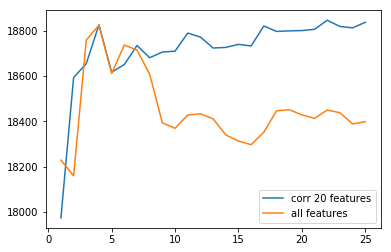

In [168]:
x = range(1,26)
plt.plot(x, acc_20.iloc[0], label="corr 20 features")
plt.plot(x, acc_all.iloc[0], label="all features")
plt.legend()
plt.show()

In [140]:
n = len(predictions_all.columns)
corr_20_acc = {}
for i in range(1, n+1):
    model_scores = pd.DataFrame()
    for j in range(i):
        model_scores["model_"+str(j)] = predictions_corr_20["model_"+str(j)]
    ensamble_score = model_scores.mean(axis=1)
    corr_20_acc["ensamble_n="+str(i)] = mean_absolute_error(ensamble_score, y_hold)

NameError: name 'predictions_corr_20' is not defined

In [ ]:
"""ALL FEATURES"""

train = pd.read_csv("../data/data_all_features.csv")

X_test = pd.read_csv("../data/test_all_features.csv")
X_test_id = pd.read_csv("../data/raw_test.csv")["Id"]

headers = X_test.columns

y_all = train["SalePrice"]
X_all = train.drop(columns=["SalePrice"])[headers]

X, X_hold, y, y_hold = train_test_split(X_all,y_all)

In [ ]:
X_hold = X_hold.reset_index()
y_hold = y_hold.reset_index()

original_index = y_hold["index"]
X_hold = X_hold.drop(columns = ["index"])
y_hold = y_hold.drop(columns = ["index"])

In [ ]:
max_models = 10
predictions, parameters, models = XGB_optimised_ensamble(X, y, X_test = X_hold, num_search = 5, num_models = max_models)
predictions_all = pd.DataFrame(predictions)

In [ ]:
all_acc = {}
for i in range(1, max_models+1):
    model_scores = pd.DataFrame()
    for j in range(i):
        model_scores["model_"+str(j)] = predictions_all["model_"+str(j)]
    ensamble_score = model_scores.mean(axis=1)
    all_acc["ensamble_n="+str(i)] = mean_absolute_error(ensamble_score, y_hold)

In [ ]:
plt.plot(all_acc.keys(), all_acc.values())
plt.plot(corr_20_acc.keys(), corr_20_acc.values())
plt.show()